In [8]:
!pip install shapely
!pip install matplotlib

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from shapely.geometry import Point, Polygon
from shapely.prepared import prep # For optimized point-in-polygon checks
from matplotlib.patches import Rectangle, Polygon as MplPolygon

In [10]:
# --- 0. Mock Data Structures and Database Functions ---

# Named tuples to represent our data records
SightingRecord = namedtuple('SightingRecord', ['sighting_id', 'species_name', 'latitude', 'longitude'])
ParkVertexRecord = namedtuple('ParkVertexRecord', ['park_id', 'sequence_number', 'latitude', 'longitude'])
ParkRecord = namedtuple('ParkRecord', ['park_id', 'park_name', 'park_type'])

# Mock Database Store (simulating tables)
MOCK_SIGHTINGS = []
MOCK_PARKS = [
    ParkRecord(1, 'Pine Ridge Conservation Park', 'State'),
    ParkRecord(2, 'Gum Tree National Park', 'National'),
    ParkRecord(3, 'Coastal Wetlands Reserve', 'State')
]
MOCK_PARK_VERTICES = [] # Stores vertices for a sample park.

# Generate some mock data
random.seed(42) # For reproducible random data

# --- Define a smaller, simpler park for better visualization ---
# Pine Ridge Conservation Park polygon (a rough rectangle for simplicity)
# Using positive values to simplify plotting, assume relative coordinates
pine_ridge_vertices_coords = [
    (10, 10), (20, 10), (20, 20), (10, 20), (10, 10) # A 10x10 square
]
for i, (lon, lat) in enumerate(pine_ridge_vertices_coords):
    MOCK_PARK_VERTICES.append(ParkVertexRecord(1, i + 1, lat, lon))

# Make it slightly irregular for more interesting point-in-polygon
# Example: Adding a small indentation
MOCK_PARK_VERTICES.append(ParkVertexRecord(1, 5, 15, 12)) # lat=15, lon=12
MOCK_PARK_VERTICES.append(ParkVertexRecord(1, 6, 10, 12)) # lat=10, lon=12
MOCK_PARK_VERTICES = sorted(MOCK_PARK_VERTICES, key=lambda v: (v.park_id, v.sequence_number))

# Ensure the polygon closes properly if needed
# The actual Polygon constructor will handle closure if the first and last points are not identical.

# Generate legless lizard sightings (some inside, some near, some outside the visualization area)
num_ll_sightings = 200
for i in range(num_ll_sightings):
    s_id = i + 1
    species = "legless lizard"
    # Roughly half inside/near the visualizable area for example
    if random.random() < 0.5:
        # Generate points within a slightly larger bbox centered around the park
        lat = random.uniform(5, 25)
        lon = random.uniform(5, 25)
    else:
        # Generate points far away
        lat = random.uniform(30, 40)
        lon = random.uniform(30, 40)
    MOCK_SIGHTINGS.append(SightingRecord(s_id, species, lat, lon))

# --- Functions to mock DB calls ---
def fetch_sightings_by_species(species_name):
    """Mocks fetching sightings for a given species."""
    # print(f"DB call: Fetching sightings for '{species_name}'...")
    return [s for s in MOCK_SIGHTINGS if s.species_name == species_name]

def fetch_park_details_by_name(park_name):
    """Mocks fetching park details and vertices."""
    # print(f"DB call: Fetching details for park '{park_name}'...")
    park_record = next((p for p in MOCK_PARKS if p.park_name == park_name), None)
    if not park_record:
        return None, None

    vertices = sorted(
        [v for v in MOCK_PARK_VERTICES if v.park_id == park_record.park_id],
        key=lambda v: v.sequence_number
    )
    return park_record, vertices

In [11]:
# --- Basic Quadtree Implementation (from previous response) ---
class QuadTree:
    def __init__(self, boundary, capacity=4, max_depth=8, depth=0):
        self.boundary = boundary # (min_lon, min_lat, max_lon, max_lat)
        self.capacity = capacity
        self.points = [] # Stores (point_id, Point_object) tuples
        self.divided = False
        self.max_depth = max_depth
        self.depth = depth
        self.children = [] # For easier iteration in plotting

    def subdivide(self):
        min_lon, min_lat, max_lon, max_lat = self.boundary
        mid_lon = (min_lon + max_lon) / 2
        mid_lat = (min_lat + max_lat) / 2

        self.northwest = QuadTree((min_lon, mid_lat, mid_lon, max_lat), self.capacity, self.max_depth, self.depth + 1)
        self.northeast = QuadTree((mid_lon, mid_lat, max_lon, max_lat), self.capacity, self.max_depth, self.depth + 1)
        self.southwest = QuadTree((min_lon, min_lat, mid_lon, mid_lat), self.capacity, self.max_depth, self.depth + 1)
        self.southeast = QuadTree((mid_lon, min_lat, max_lon, mid_lat), self.capacity, self.max_depth, self.depth + 1)
        self.divided = True
        self.children = [self.northwest, self.northeast, self.southwest, self.southeast]

        # Redistribute points to new children
        for p_id, p_obj in self.points:
            self._insert_into_child(p_id, p_obj)
        self.points = [] # Clear points once subdivided

    def _insert_into_child(self, p_id, p_obj):
        # Shapely Point.x is longitude, Point.y is latitude
        if self.northwest.contains_point(p_obj): self.northwest.insert(p_id, p_obj); return True
        if self.northeast.contains_point(p_obj): self.northeast.insert(p_id, p_obj); return True
        if self.southwest.contains_point(p_obj): self.southwest.insert(p_id, p_obj); return True
        if self.southeast.contains_point(p_obj): self.southeast.insert(p_id, p_obj); return True
        return False # Should not happen if point is within parent boundary

    def contains_point(self, point_obj):
        min_lon, min_lat, max_lon, max_lat = self.boundary
        # Adjusted slightly for boundary points to be inclusive on min, exclusive on max for a clean split
        return min_lon <= point_obj.x < max_lon and min_lat <= point_obj.y < max_lat

    def insert(self, point_id, point_obj):
        if not self.contains_point(point_obj):
            return False

        if not self.divided and (len(self.points) < self.capacity or self.depth >= self.max_depth):
            self.points.append((point_id, point_obj))
            return True
        
        if not self.divided:
            self.subdivide()
        
        return self._insert_into_child(point_id, point_obj)

    def query_range_mbr(self, query_boundary): # query_boundary is (min_lon, min_lat, max_lon, max_lat)
        self_min_lon, self_min_lat, self_max_lon, self_max_lat = self.boundary
        q_min_lon, q_min_lat, q_max_lon, q_max_lat = query_boundary

        # Check for intersection between this node's boundary and the query boundary
        if q_min_lon >= self_max_lon or q_max_lon <= self_min_lon or \
           q_min_lat >= self_max_lat or q_max_lat <= self_min_lat:
            return [] # No intersection, prune branch

        found_points = []
        if self.divided:
            for child in self.children:
                found_points.extend(child.query_range_mbr(query_boundary))
        else:
            for p_id, p_obj in self.points:
                # Actual point must be within query rectangle
                if q_min_lon <= p_obj.x <= q_max_lon and q_min_lat <= p_obj.y <= q_max_lat:
                    found_points.append((p_id, p_obj))
        return found_points

    # Method to get all boundaries for plotting
    def get_boundaries(self):
        boundaries = [self.boundary]
        if self.divided:
            for child in self.children:
                boundaries.extend(child.get_boundaries())
        return boundaries

In [14]:
# --- Plotting Function ---
def plot_quadtree_state(title, points_ll, quadtree_obj, park_polygon_mpl_coords=None, park_bbox_mpl_coords=None,
                        candidate_points=None, final_points_in_park=None, save_path=None):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    # Determine plot limits based on global or data extent
    all_lons = [s.longitude for s in MOCK_SIGHTINGS] + [v.longitude for v in MOCK_PARK_VERTICES]
    all_lats = [s.latitude for s in MOCK_SIGHTINGS] + [v.latitude for v in MOCK_PARK_VERTICES]
    
    # Filter points for plotting within a reasonable range
    plot_lons_all = [s.longitude for s in points_ll if all_lons[0]-5 <= s.longitude <= all_lons[-1]+5 and all_lats[0]-5 <= s.latitude <= all_lats[-1]+5]
    plot_lats_all = [s.latitude for s in points_ll if all_lons[0]-5 <= s.longitude <= all_lons[-1]+5 and all_lats[0]-5 <= s.latitude <= all_lats[-1]+5]
    
    ax.set_xlim(min(all_lons)-5, max(all_lons)+5)
    ax.set_ylim(min(all_lats)-5, max(all_lats)+5)

    # 1. Plot all legless lizard sightings (faintly)
    ax.scatter([s.longitude for s in points_ll], [s.latitude for s in points_ll],
               color='lightgray', marker='o', s=10, zorder=1, label='All Species Sightings (LL)')

    # 2. Plot Quadtree boundaries
    for b in quadtree_obj.get_boundaries():
        min_lon, min_lat, max_lon, max_lat = b
        rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         fill=False, edgecolor='blue', linewidth=0.5, linestyle=':', alpha=0.6)
        ax.add_patch(rect)

    # 3. Plot Park Polygon
    if park_polygon_mpl_coords:
        mpl_polygon = MplPolygon(park_polygon_mpl_coords, closed=True,
                                 facecolor='lightgreen', edgecolor='green', linewidth=2, alpha=0.5, zorder=2, label='Park Polygon')
        ax.add_patch(mpl_polygon)

    # 4. Plot Park Bounding Box (if provided)
    if park_bbox_mpl_coords:
        min_lon, min_lat, max_lon, max_lat = park_bbox_mpl_coords
        rect_bbox = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                              fill=False, edgecolor='red', linewidth=2, linestyle='--', zorder=3, label='Park Bounding Box')
        ax.add_patch(rect_bbox)

    # 5. Plot Candidate Points (from Quadtree query)
    if candidate_points:
        cand_lons = [p.x for _, p in candidate_points]
        cand_lats = [p.y for _, p in candidate_points]
        ax.scatter(cand_lons, cand_lats, color='orange', marker='s', s=30, zorder=4, label='Quadtree Candidates')

    # 6. Plot Final Points (after Point-in-Polygon test)
    if final_points_in_park:
        # Need to map s_id back to actual point objects from candidate_points or original sightings
        final_point_objects = [(p_obj.x, p_obj.y) for s_id, p_obj in candidate_points if s_id in final_points_in_park]
        ax.scatter([p[0] for p in final_point_objects], [p[1] for p in final_point_objects],
                   color='darkred', marker='P', s=50, zorder=5, label='Final Sightings in Park')

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

--- Problem 1 Execution Plan with Visualizations ---

Step 1: Retrieving all 'legless lizard' sighting locations...
  Fetched 200 sightings for 'legless lizard'.


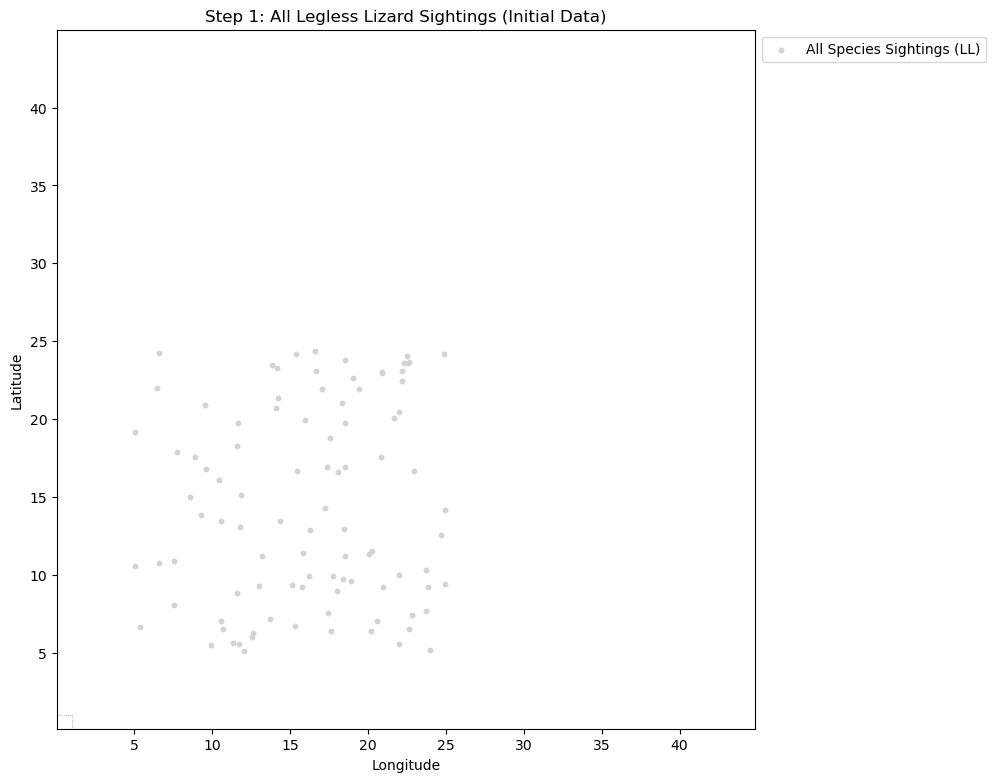

  Visualization created: step1_all_sightings.png


In [15]:
# --- Main Execution Plan with Visualizations ---
target_species = "legless lizard"
target_park_name = "Pine Ridge Conservation Park"

print("--- Problem 1 Execution Plan with Visualizations ---")

# Step 1: Retrieve all required sighting locations for the target species
print(f"\nStep 1: Retrieving all '{target_species}' sighting locations...")
legless_lizard_sightings = fetch_sightings_by_species(target_species)
print(f"  Fetched {len(legless_lizard_sightings)} sightings for '{target_species}'.")

# Prepare points for Quadtree insertion (convert records to (id, Point) tuples)
points_for_quadtree = [(s.sighting_id, Point(s.longitude, s.latitude)) for s in legless_lizard_sightings]

# Visualization 1: Initial points
# Plot current sightings (limited to visualize area)
visual_ll_sightings_plot = [s for s in legless_lizard_sightings if 0 <= s.longitude <= 30 and 0 <= s.latitude <= 30]
plot_quadtree_state('Step 1: All Legless Lizard Sightings (Initial Data)',
                    visual_ll_sightings_plot, quadtree_obj=QuadTree((0,0,1,1),0,0,0), # Dummy for just points
                    save_path='step1_all_sightings.png')
print("  Visualization created: step1_all_sightings.png")
# Dummy Quadtree just to get the overall boundary plotted correctly below.


Step 2: Building Quadtree on these sighting locations...


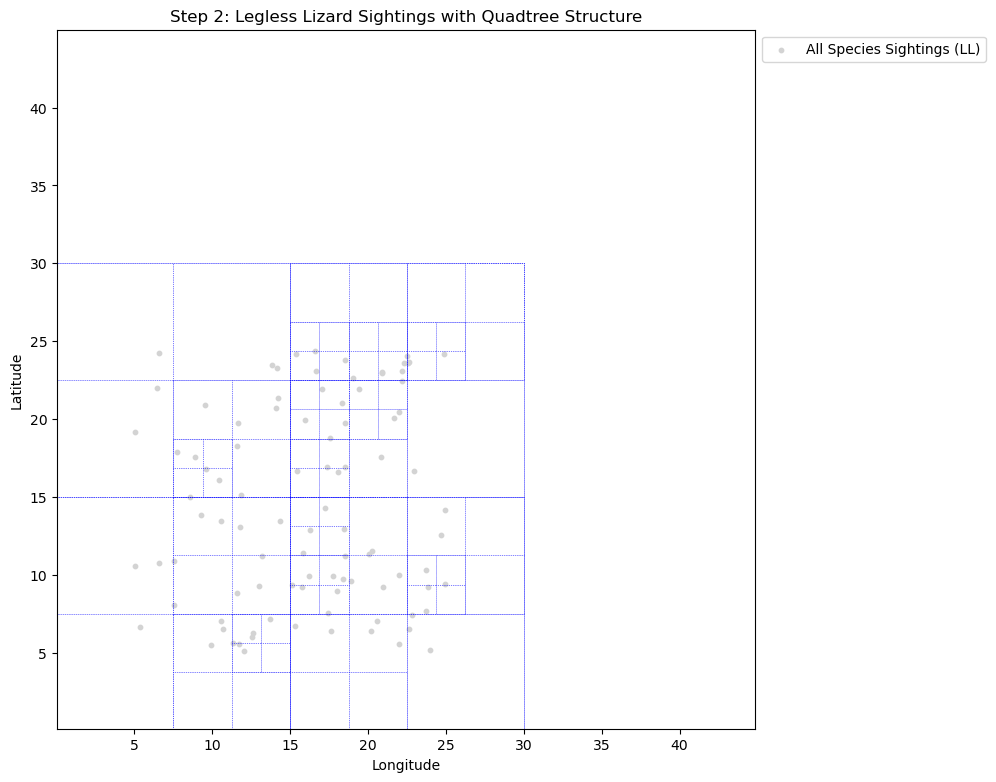

  Visualization created: step2_quadtree_built.png


In [16]:
# Step 2: Build a Quadtree on these sighting locations
print("\nStep 2: Building Quadtree on these sighting locations...")
# Determine overall bounds for the Quadtree - using a larger area than the park for visualization
global_min_lon, global_min_lat, global_max_lon, global_max_lat = (0, 0, 30, 30) # Visualizable area
quadtree_boundary = (global_min_lon, global_min_lat, global_max_lon, global_max_lat)
quadtree = QuadTree(quadtree_boundary, capacity=3, max_depth=4) # Smaller capacity/depth for clearer visualization

for s_id, point_obj in points_for_quadtree:
    if quadtree.contains_point(point_obj): # Insert only points within visualization area
        quadtree.insert(s_id, point_obj)

# Visualization 2: Quadtree structure with points
plot_quadtree_state('Step 2: Legless Lizard Sightings with Quadtree Structure',
                    visual_ll_sightings_plot, quadtree_obj=quadtree,
                    save_path='step2_quadtree_built.png')
print("  Visualization created: step2_quadtree_built.png")


Step 3: Getting the required park polygon for 'Pine Ridge Conservation Park'...
  Polygon for 'Pine Ridge Conservation Park' constructed. Bounding box: (10.0, 10.0, 20.0, 20.0)


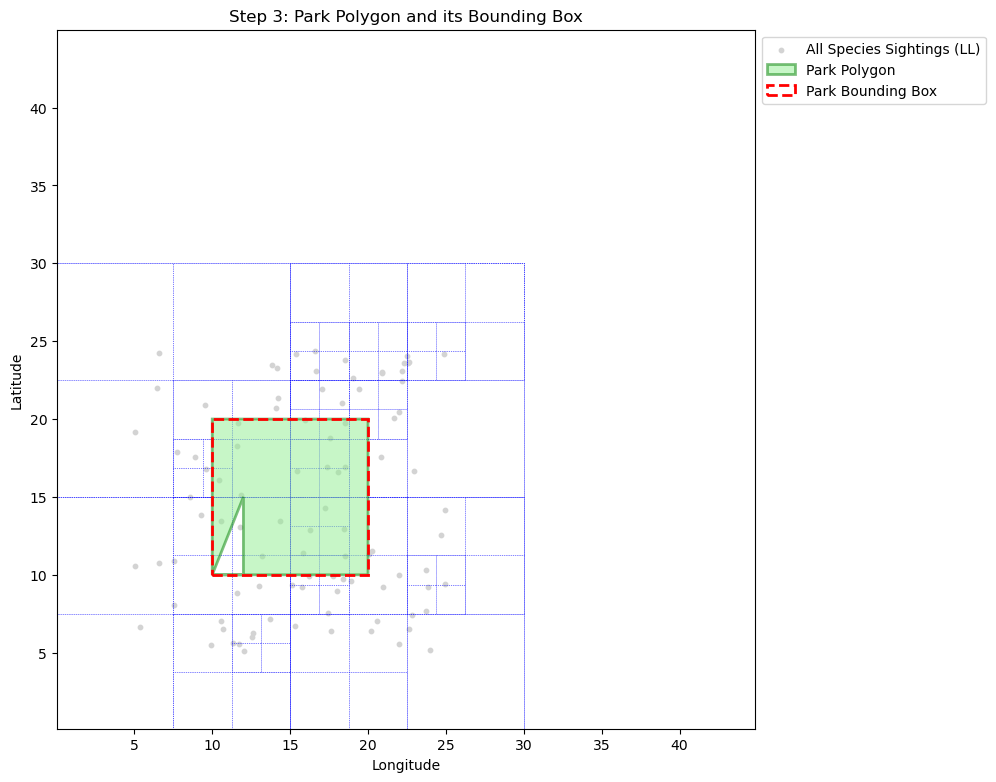

  Visualization created: step3_park_and_bbox.png


In [17]:
# Step 3: Get the required park polygon
print(f"\nStep 3: Getting the required park polygon for '{target_park_name}'...")
park_record, park_vertices = fetch_park_details_by_name(target_park_name)

if not park_record or not park_vertices:
    print(f"Error: Park '{target_park_name}' not found or has no vertices.")
    exit()

# Shapely Polygon expects (lon, lat) tuples
park_polygon_coords = [(v.longitude, v.latitude) for v in park_vertices]
park_polygon = Polygon(park_polygon_coords)
prepared_park_polygon = prep(park_polygon) # Optimize polygon for repeated queries

# For plotting, coordinates should be (lon, lat)
park_polygon_mpl_coords = [(v.longitude, v.latitude) for v in park_vertices]
park_min_lon, park_min_lat, park_max_lon, park_max_lat = park_polygon.bounds
park_bbox_mpl_coords = (park_min_lon, park_min_lat, park_max_lon, park_max_lat)
print(f"  Polygon for '{park_record.park_name}' constructed. Bounding box: {park_polygon.bounds}")

# Visualization 3: Park Polygon and its Bounding Box
plot_quadtree_state('Step 3: Park Polygon and its Bounding Box',
                    visual_ll_sightings_plot, quadtree_obj=quadtree,
                    park_polygon_mpl_coords=park_polygon_mpl_coords,
                    park_bbox_mpl_coords=park_bbox_mpl_coords,
                    save_path='step3_park_and_bbox.png')
print("  Visualization created: step3_park_and_bbox.png")


Step 4: Querying Quadtree for candidate sightings within park's bounding box...
  Quadtree returned 20 candidate sightings within the park's bounding box.


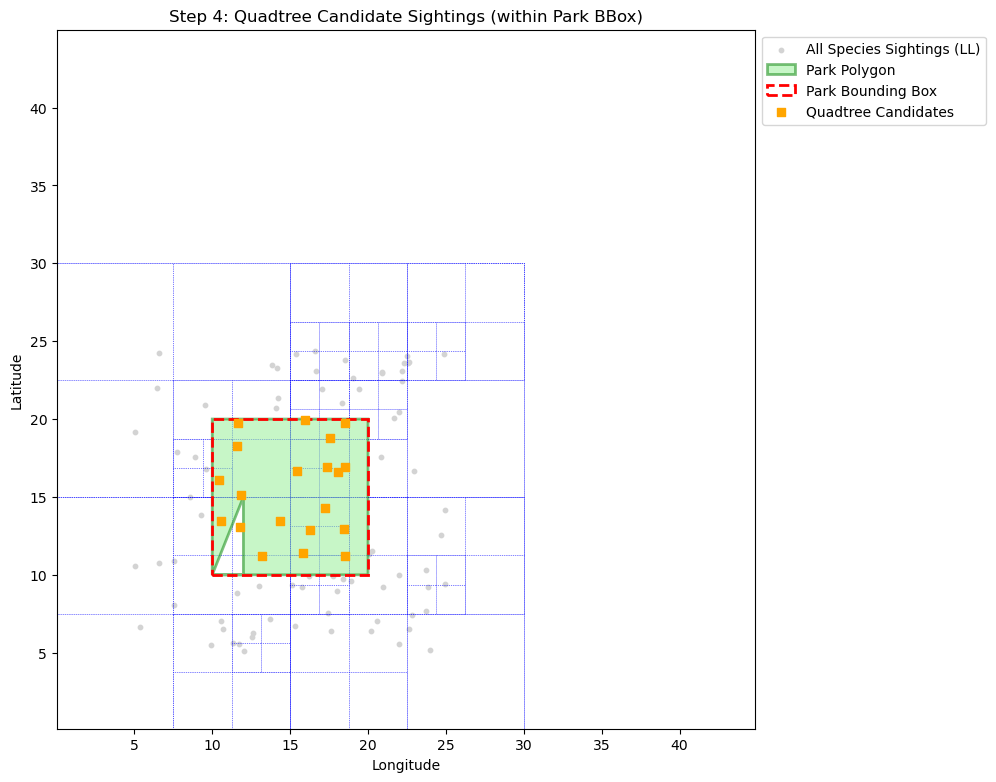

  Visualization created: step4_quadtree_candidates.png


In [18]:
# Step 4: Perform a spatial query on the Quadtree using the park's bounding box
print("\nStep 4: Querying Quadtree for candidate sightings within park's bounding box...")
park_bbox_query = (park_min_lon, park_min_lat, park_max_lon, park_max_lat)

candidate_sightings_from_quadtree = quadtree.query_range_mbr(park_bbox_query)
print(f"  Quadtree returned {len(candidate_sightings_from_quadtree)} candidate sightings "
      f"within the park's bounding box.")

# Visualization 4: Candidate points identified by Quadtree
plot_quadtree_state('Step 4: Quadtree Candidate Sightings (within Park BBox)',
                    visual_ll_sightings_plot, quadtree_obj=quadtree,
                    park_polygon_mpl_coords=park_polygon_mpl_coords,
                    park_bbox_mpl_coords=park_bbox_mpl_coords,
                    candidate_points=candidate_sightings_from_quadtree,
                    save_path='step4_quadtree_candidates.png')
print("  Visualization created: step4_quadtree_candidates.png")

In [19]:
# Step 5: Refine (Point-in-Polygon) for each candidate sighting
print("\nStep 5: Performing precise Point-in-Polygon test for candidates...")
sightings_in_park_ids = []
for s_id, point_obj in candidate_sightings_from_quadtree:
    if prepared_park_polygon.contains(point_obj):
        sightings_in_park_ids.append(s_id)
print(f"  Identified {len(sightings_in_park_ids)} sightings actually inside '{target_park_name}'.")


Step 5: Performing precise Point-in-Polygon test for candidates...
  Identified 19 sightings actually inside 'Pine Ridge Conservation Park'.



Step 6: Final Result -> Number of 'legless lizard' sightings in 'Pine Ridge Conservation Park': 19


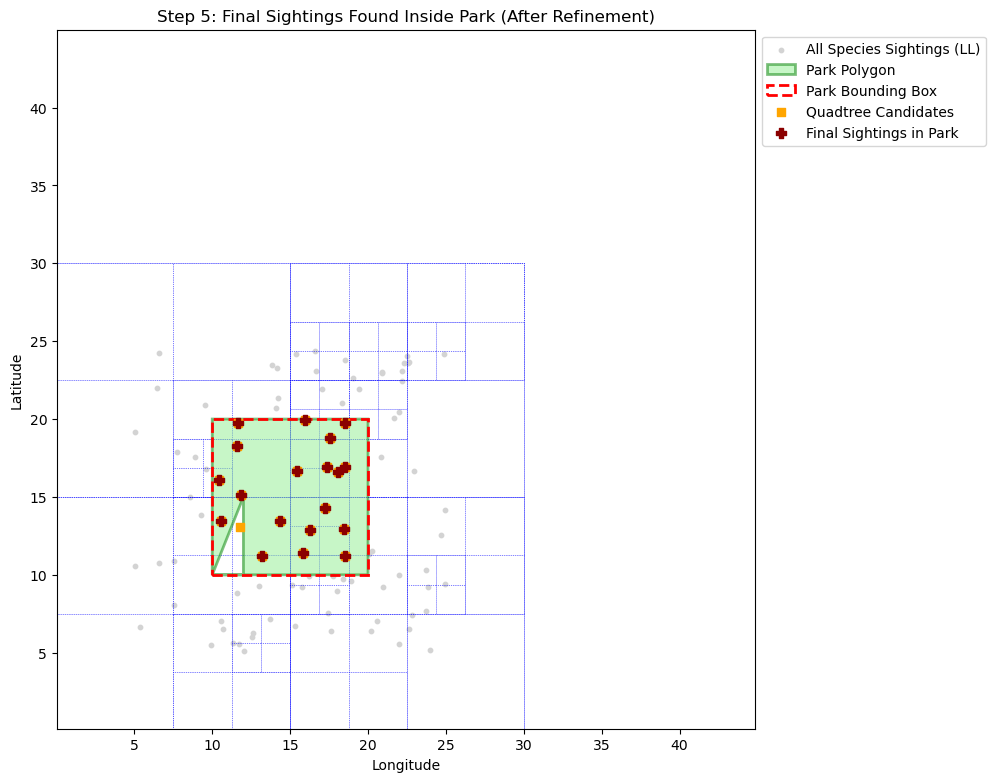

  Visualization created: step5_final_sightings.png

--- Execution Plan Complete ---


In [20]:
# Step 6: Count the final result
final_count = len(sightings_in_park_ids)
print(f"\nStep 6: Final Result -> Number of '{target_species}' sightings in '{target_park_name}': {final_count}")

# Visualization 5: Final identified points
plot_quadtree_state('Step 5: Final Sightings Found Inside Park (After Refinement)',
                    visual_ll_sightings_plot, quadtree_obj=quadtree,
                    park_polygon_mpl_coords=park_polygon_mpl_coords,
                    park_bbox_mpl_coords=park_bbox_mpl_coords,
                    candidate_points=candidate_sightings_from_quadtree, # Still show candidates faintly
                    final_points_in_park=sightings_in_park_ids,
                    save_path='step5_final_sightings.png')
print("  Visualization created: step5_final_sightings.png")

print("\n--- Execution Plan Complete ---")

In [21]:
!pip install rtree shapely

In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from shapely.geometry import Polygon, Point
from shapely.prepared import prep
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from rtree import index # R-tree library
import math

In [23]:
# --- 0. Mock Data Structures and Database Functions ---

WetlandRecord = namedtuple('WetlandRecord', ['wetland_id', 'wetland_name'])
WetlandVertexRecord = namedtuple('WetlandVertexRecord', ['wetland_id', 'sequence_number', 'latitude', 'longitude'])
ParkRecord = namedtuple('ParkRecord', ['park_id', 'park_name', 'park_type'])
ParkVertexRecord = namedtuple('ParkVertexRecord', ['park_id', 'sequence_number', 'latitude', 'longitude'])

MOCK_WETLANDS = []
MOCK_WETLAND_VERTICES = []
MOCK_PARKS = []
MOCK_PARK_VERTICES = []

random.seed(42) # For reproducible random data

# Generate Mock Wetlands
wetland_names = ["Riverbend Marsh", "Willow Creek Bog", "Great Salt Flats", "Crystal Lake Shore"]
wetland_base_coords = [
    (10, 5), # Riverbend Marsh
    (25, 15), # Willow Creek Bog
    (12, 28), # Great Salt Flats
    (28, 5) # Crystal Lake Shore
]
for i, name in enumerate(wetland_names):
    w_id = i + 1
    MOCK_WETLANDS.append(WetlandRecord(w_id, name))
    center_lon, center_lat = wetland_base_coords[i]
    # Create simple rectangular/slightly irregular polygons for wetlands
    vertices = []
    # Make them 4x4 or 5x5 roughly
    lon_range = 2.0 + random.random() * 1.0
    lat_range = 2.0 + random.random() * 1.0
    vertices.append((center_lon - lon_range/2, center_lat - lat_range/2))
    vertices.append((center_lon + lon_range/2, center_lat - lat_range/2))
    vertices.append((center_lon + lon_range/2 - random.random()*1, center_lat + lat_range/2 - random.random()*1)) # Slight irregularity
    vertices.append((center_lon - lon_range/2 + random.random()*1, center_lat + lat_range/2 + random.random()*1)) # Slight irregularity
    vertices.append(vertices[0]) # Close the polygon

    for j, (lon, lat) in enumerate(vertices):
        MOCK_WETLAND_VERTICES.append(WetlandVertexRecord(w_id, j + 1, lat, lon))

# Generate Mock Forest Parks (State or National)
park_types = ["State", "National"]
park_names = ["Central Forest Park", "Western Mountain Preserve", "Eastern Hills Park", "Southern Wilderness National Park"]
park_base_coords = [
    (15, 15), # Central Forest Park (contains Riverbend Marsh potentially)
    (5, 20),  # Western Mountain Preserve (contains Great Salt Flats potentially)
    (20, 20), # Eastern Hills Park (contains Willow Creek Bog potentially)
    (20, 10) # Southern Wilderness National Park (might contain Crystal Lake Shore)
]
for i, name in enumerate(park_names):
    p_id = i + 1
    p_type = random.choice(park_types)
    MOCK_PARKS.append(ParkRecord(p_id, name, p_type))
    center_lon, center_lat = park_base_coords[i]
    
    # Make parks larger, around 8x8 or 10x10 roughly
    lon_range = 4.0 + random.random() * 2.0
    lat_range = 4.0 + random.random() * 2.0

    vertices = []
    vertices.append((center_lon - lon_range/2, center_lat - lat_range/2))
    vertices.append((center_lon + lon_range/2, center_lat - lat_range/2))
    vertices.append((center_lon + lon_range/2, center_lat + lat_range/2))
    vertices.append((center_lon - lon_range/2, center_lat + lat_range/2))
    vertices.append(vertices[0]) # Close the polygon

    # Add specific park configurations for containing wetlands or not
    if name == "Central Forest Park": # Should contain Riverbend Marsh
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 1, 3, 8))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 2, 3, 18))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 3, 18, 18))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 4, 18, 8))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 5, 3, 8))
    elif name == "Western Mountain Preserve": # Contains Great Salt Flats
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 1, 25, 8))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 2, 25, 18))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 3, 30, 18))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 4, 30, 8))
        MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, 5, 25, 8))
    else: # Use generated vertices for others
        v_idx = 0
        for lon, lat in vertices:
            v_idx += 1
            MOCK_PARK_VERTICES.append(ParkVertexRecord(p_id, v_idx, lat, lon))


def fetch_all_wetlands():
    """Mocks fetching all wetland polygons."""
    print("DB call: Fetching all wetland polygons...")
    all_wetlands = {}
    for w_rec in MOCK_WETLANDS:
        vertices = sorted(
            [v for v in MOCK_WETLAND_VERTICES if v.wetland_id == w_rec.wetland_id],
            key=lambda v: v.sequence_number
        )
        if vertices:
            # Shapely Polygon expects (lon, lat) tuples
            poly_coords = [(v.longitude, v.latitude) for v in vertices]
            all_wetlands[w_rec.wetland_id] = (w_rec.wetland_name, Polygon(poly_coords))
    return all_wetlands

def fetch_parks_by_type(park_types_list):
    """Mocks fetching park polygons for specified types."""
    print(f"DB call: Fetching parks of types {park_types_list}...")
    relevant_parks = {}
    for p_rec in MOCK_PARKS:
        if p_rec.park_type in park_types_list:
            vertices = sorted(
                [v for v in MOCK_PARK_VERTICES if v.park_id == p_rec.park_id],
                key=lambda v: v.sequence_number
            )
            if vertices:
                poly_coords = [(v.longitude, v.latitude) for v in vertices]
                relevant_parks[p_rec.park_id] = (p_rec.park_name, p_rec.park_type, Polygon(poly_coords))
    return relevant_parks

In [47]:
# --- Plotting Function ---
def plot_r_tree_state(title, wetlands_data, parks_data, legend=False, r_tree_idx=None,
                      candidate_wetland_ids=None, final_wetland_ids=None, save_path=None):
    plt.figure(figsize=(12, 10))
    ax = plt.gca()

    # Determine plot limits based on global or data extent
    all_lons = []
    all_lats = []
    for wid, (w_name, w_poly) in wetlands_data.items():
        all_lons.extend([v[0] for v in w_poly.exterior.coords])
        all_lats.extend([v[1] for v in w_poly.exterior.coords])
    for pid, (p_name, p_type, p_poly) in parks_data.items():
        all_lons.extend([v[0] for v in p_poly.exterior.coords])
        all_lats.extend([v[1] for v in p_poly.exterior.coords])

    # Dynamic limits with some padding
    min_x, max_x = min(all_lons) - 2, max(all_lons) + 2
    min_y, max_y = min(all_lats) - 2, max(all_lats) + 2
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    # 1. Plot all Wetlands (faintly)
    for wid, (w_name, w_poly) in wetlands_data.items():
        w_mpl_poly = MplPolygon(list(w_poly.exterior.coords), closed=True,
                                facecolor='skyblue', edgecolor='darkblue', linewidth=0.5, alpha=0.3, zorder=1)
        ax.add_patch(w_mpl_poly)
        ax.text(w_poly.centroid.x, w_poly.centroid.y, f"W{wid}", fontsize=8, ha='center', va='center', color='darkblue')

    # 2. Plot relevant Parks
    for pid, (p_name, p_type, p_poly) in parks_data.items():
        p_mpl_poly = MplPolygon(list(p_poly.exterior.coords), closed=True,
                                facecolor='lightgreen', edgecolor='green', linewidth=2, alpha=0.4, zorder=2)
        ax.add_patch(p_mpl_poly)
        ax.text(p_poly.centroid.x, p_poly.centroid.y, f"P{pid}\n({p_type})", fontsize=9, ha='center', va='center', color='darkgreen')

    # 3. Plot MBRs from R-tree (if R-tree is provided and for visualization step)
    if r_tree_idx and title == 'Step 2: R-tree Built on Wetland MBRs': # Only draw R-tree internal structure if this specific step
        # This is a very simplified way to show R-tree structure, typically more complex with nested rectangles
        # For simplicity, we just plot bounding boxes of all objects indexed
        for wid in r_tree_idx.intersection(r_tree_idx.bounds):
            coords = r_tree_idx.bounds # (min_x, min_y, max_x, max_y)
            rect = Rectangle((coords[0], coords[1]), coords[2] - coords[0], coords[3] - coords[1],
                             fill=False, edgecolor='blue', linestyle=':', linewidth=1, alpha=0.7, zorder=3)
            ax.add_patch(rect)


    # 4. Highlight Candidate Wetlands (returned by R-tree query for a park)
    if candidate_wetland_ids:
        # Get MBR of Query Park for highlighting
        query_park_poly = next(iter(parks_data.values()))[2] # Assuming a single query park for visualization
        qp_mb = query_park_poly.bounds
        q_rect = Rectangle((qp_mb[0], qp_mb[1]), qp_mb[2] - qp_mb[0], qp_mb[3] - qp_mb[1],
                          fill=False, edgecolor='red', linewidth=3, linestyle='--', zorder=4, label='Query Park MBR')
        ax.add_patch(q_rect)
        
        for wid in candidate_wetland_ids:
            w_name, w_poly = wetlands_data[wid]
            w_mpl_poly = MplPolygon(list(w_poly.exterior.coords), closed=True,
                                    facecolor='red', edgecolor='red', linewidth=2, alpha=0.4, zorder=5)
            ax.add_patch(w_mpl_poly)
            ax.text(w_poly.centroid.x, w_poly.centroid.y, f"W{wid}\n(Candidate)", fontsize=8, ha='center', va='center', color='darkred')
        # Add legend for these candidates only once
        if candidate_wetland_ids:
            ax.scatter([],[], marker='s', color='red', label='R-tree Candidates')


    # 5. Highlight Final Wetlands (after Polygon-in-Polygon test)
    if final_wetland_ids:
        for wid in final_wetland_ids:
            w_name, w_poly = wetlands_data[wid]
            w_mpl_poly = MplPolygon(list(w_poly.exterior.coords), closed=True,
                                    facecolor='darkmagenta', edgecolor='darkmagenta', linewidth=3, alpha=0.6, zorder=6)
            ax.add_patch(w_mpl_poly)
            ax.text(w_poly.centroid.x, w_poly.centroid.y, f"W{wid}\n(Final In Park)", fontsize=9, ha='center', va='center', color='white', weight='bold')
        ax.scatter([],[], marker='o', color='darkmagenta', label='Final Wetlands in Park')


    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal', adjustable='box')
    if legend:
        ax.legend(loc='upper right', bbox_to_anchor=(1.25,1)) # Place legend outside for clarity
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

--- Problem 2 Execution Plan with Visualizations ---

Step 1: Retrieving all wetland polygon geometries...
DB call: Fetching all wetland polygons...
  Fetched 4 wetland polygons.
DB call: Fetching parks of types ['State', 'National', 'Other']...


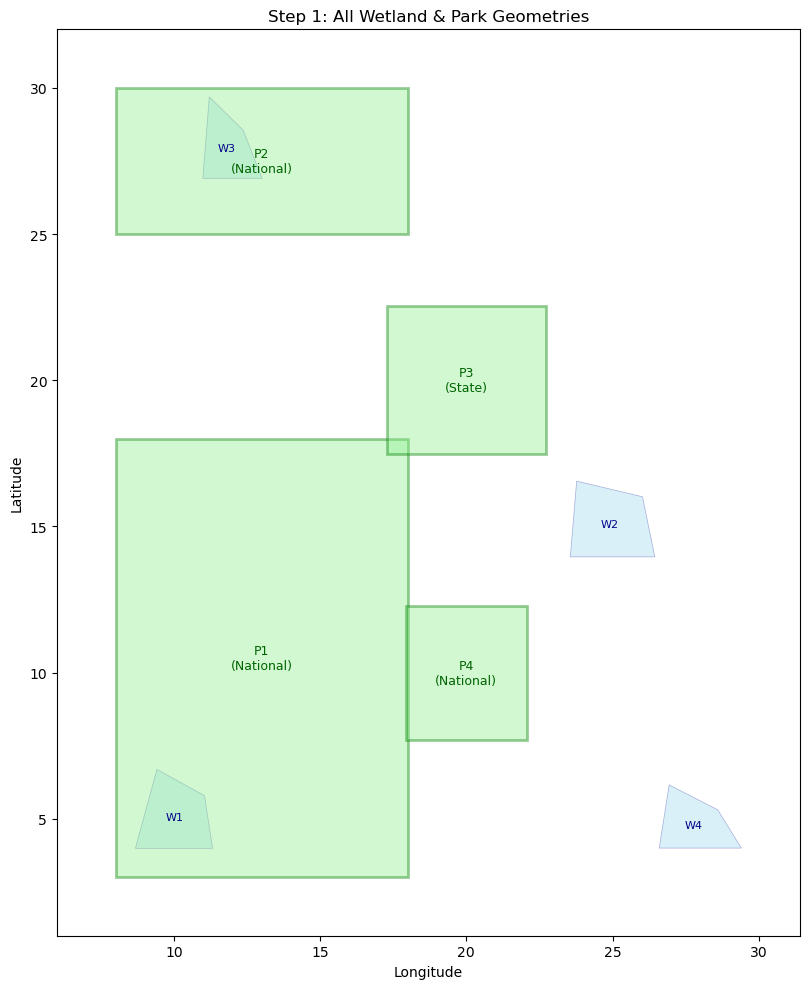

  Visualization created: step1_all_geometries.png


In [48]:
# --- Main Execution Plan ---

print("--- Problem 2 Execution Plan with Visualizations ---")
target_park_types = ["State", "National"]

# Step 1: Retrieve all required wetland polygons
print(f"\nStep 1: Retrieving all wetland polygon geometries...")
all_wetlands = fetch_all_wetlands() # Dictionary: {w_id: (w_name, shapely.Polygon)}
print(f"  Fetched {len(all_wetlands)} wetland polygons.")

# Visualization 1: All Wetlands and Parks
all_parks_for_viz = fetch_parks_by_type(['State', 'National', 'Other']) # Fetch all parks for initial viz
plot_r_tree_state('Step 1: All Wetland & Park Geometries',
                  all_wetlands, all_parks_for_viz,
                  save_path='step1_all_geometries.png')
print("  Visualization created: step1_all_geometries.png")


Step 2: Building R-tree on wetland polygon MBRs...
<class 'rtree.index.Index'>
<class 'rtree.index.Index'>
<class 'rtree.index.Index'>
<class 'rtree.index.Index'>
  R-tree built successfully on wetland MBRs.


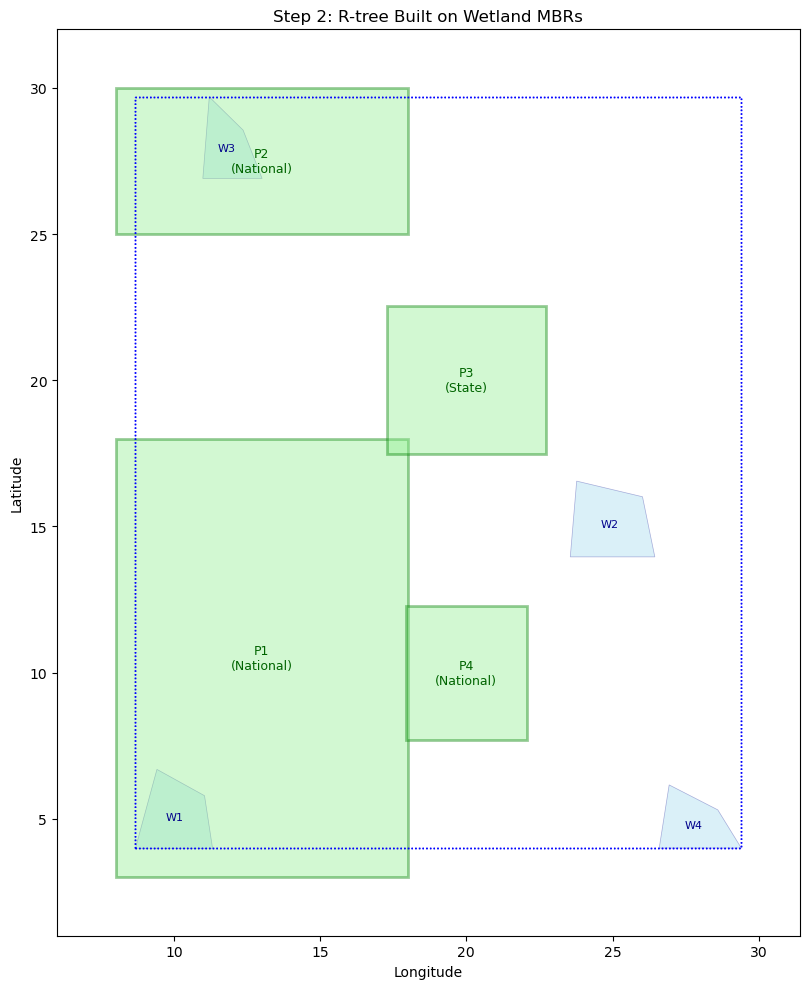

  Visualization created: step2_r_tree_built.png


In [49]:
# Step 2: Build an R-tree on these wetland polygons
print("\nStep 2: Building R-tree on wetland polygon MBRs...")
idx = index.Index()
# rtree index requires (id, (min_x, min_y, max_x, max_y)) tuples
for wid, (w_name, w_poly) in all_wetlands.items():
    idx.insert(wid, w_poly.bounds) # w_poly.bounds returns (min_x, min_y, max_x, max_y)
    print(type(idx))
print("  R-tree built successfully on wetland MBRs.")

# Visualization 2: R-tree structure (showing MBRs of indexed wetlands)
# Rtree doesn't expose internal node structure easily, so we just show object MBRs indexed
plot_r_tree_state('Step 2: R-tree Built on Wetland MBRs',
                  all_wetlands, all_parks_for_viz,
                  r_tree_idx=idx,
                  save_path='step2_r_tree_built.png')
print("  Visualization created: step2_r_tree_built.png")

In [50]:
# Step 3: Get the required park polygons (State or National)
print(f"\nStep 3: Retrieving 'State' or 'National' forest park polygons...")
relevant_parks = fetch_parks_by_type(target_park_types) # Dictionary: {p_id: (p_name, p_type, shapely.Polygon)}
print(f"  Fetched {len(relevant_parks)} relevant park polygons.")


Step 3: Retrieving 'State' or 'National' forest park polygons...
DB call: Fetching parks of types ['State', 'National']...
  Fetched 4 relevant park polygons.



Step 4 & 5: Performing R-tree query (Filter) and Polygon-in-Polygon test (Refine)...
  Processing park: Central Forest Park (National)
    R-tree found 1 candidate wetlands for 'Central Forest Park'.


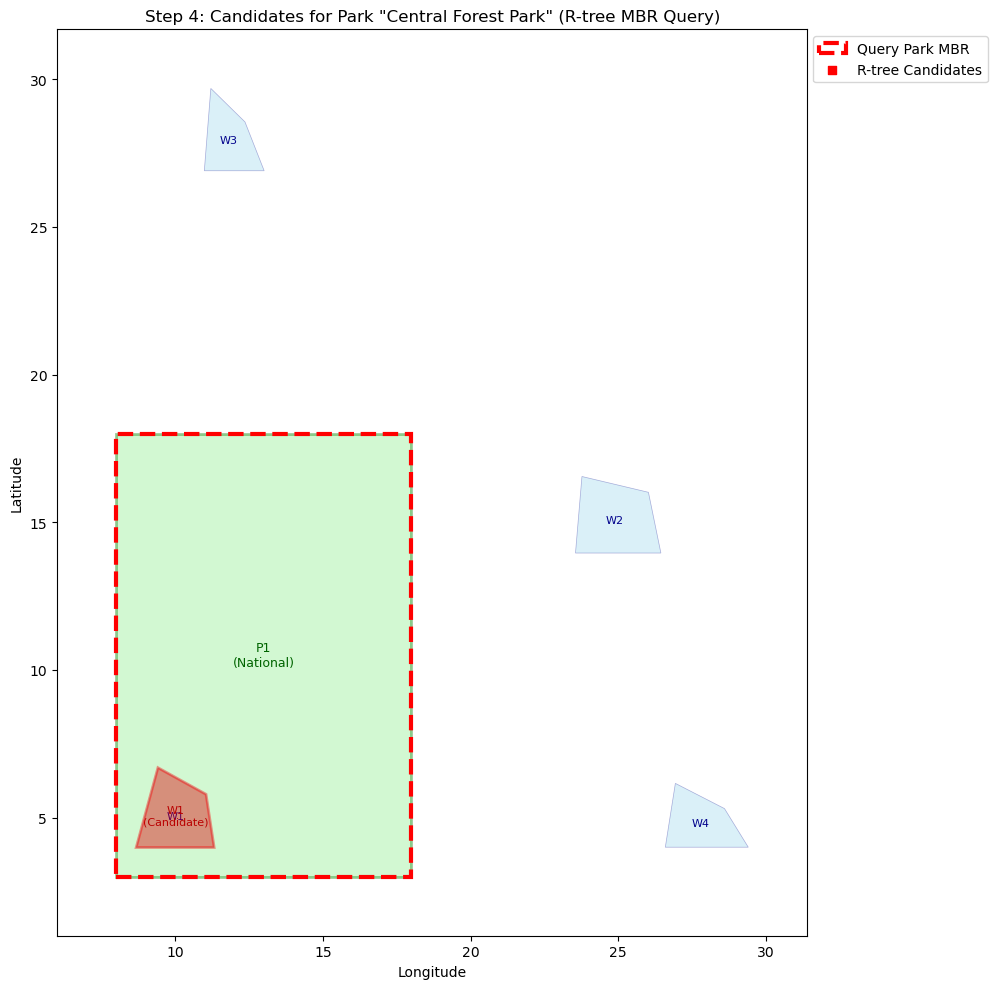

      Visualization created: step4_candidates_for_park_1.png
    1 wetlands definitively inside 'Central Forest Park'.
  Processing park: Western Mountain Preserve (National)
    R-tree found 1 candidate wetlands for 'Western Mountain Preserve'.
    1 wetlands definitively inside 'Western Mountain Preserve'.
  Processing park: Eastern Hills Park (State)
    R-tree found 0 candidate wetlands for 'Eastern Hills Park'.
    0 wetlands definitively inside 'Eastern Hills Park'.
  Processing park: Southern Wilderness National Park (National)
    R-tree found 0 candidate wetlands for 'Southern Wilderness National Park'.
    0 wetlands definitively inside 'Southern Wilderness National Park'.


In [51]:
# Step 4: Perform spatial queries (Filter Stage) and Refine (Polygon-in-Polygon Test)
# We will combine steps 4 and 5 for a single iteration and visualization
print("\nStep 4 & 5: Performing R-tree query (Filter) and Polygon-in-Polygon test (Refine)...")
wetlands_inside_any_park_ids = set()

for p_id, (p_name, p_type, p_poly) in relevant_parks.items():
    print(f"  Processing park: {p_name} ({p_type})")
    # Optimize park polygon for repeated contains checks
    prepared_p_poly = prep(p_poly)

    # R-tree Query (Filter Stage): Find candidate wetlands whose MBRs intersect the park's MBR
    park_mbr = p_poly.bounds # (min_x, min_y, max_x, max_y)
    candidate_wetland_ids = list(idx.intersection(park_mbr))
    print(f"    R-tree found {len(candidate_wetland_ids)} candidate wetlands for '{p_name}'.")

    # Visualization of candidates for the first park only, for clarity
    if p_id == next(iter(relevant_parks.keys())) : # Just visualize the first park's candidates
        plot_r_tree_state(f'Step 4: Candidates for Park "{p_name}" (R-tree MBR Query)',
                          all_wetlands, {p_id: relevant_parks[p_id]}, # Only this park for context
                          r_tree_idx=idx, candidate_wetland_ids=candidate_wetland_ids, legend=True,
                          save_path=f'step4_candidates_for_park_{p_id}.png')
        print(f"      Visualization created: step4_candidates_for_park_{p_id}.png")

    # Polygon-in-Polygon Test (Refine Stage):
    current_park_contained_wetlands = []
    for wid in candidate_wetland_ids:
        w_name, w_poly = all_wetlands[wid]
        if prepared_p_poly.contains(w_poly): # Precise containment check
            wetlands_inside_any_park_ids.add(wid)
            current_park_contained_wetlands.append(wid)
    print(f"    {len(current_park_contained_wetlands)} wetlands definitively inside '{p_name}'.")


Step 6: Collecting and printing final results...

Total 2 wetlands found inside 'State' or 'National' forest parks:
- Riverbend Marsh
- Great Salt Flats


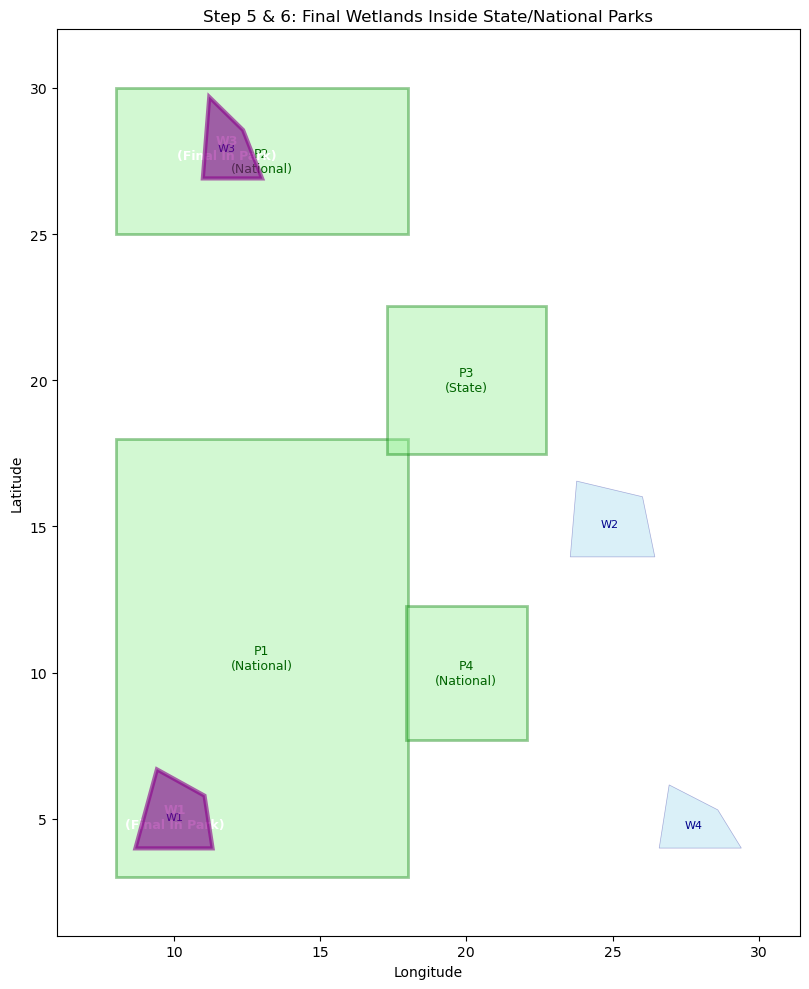

  Visualization created: step5_final_wetlands_in_parks.png

--- Execution Plan Complete ---


In [52]:
# Step 5: Collect and print final results
print("\nStep 6: Collecting and printing final results...")
final_wetland_names = [all_wetlands[wid][0] for wid in sorted(list(wetlands_inside_any_park_ids))]

print(f"\nTotal {len(final_wetland_names)} wetlands found inside 'State' or 'National' forest parks:")
for w_name in final_wetland_names:
    print(f"- {w_name}")

# Final Visualization: All parks and the wetlands conclusively found to be inside
plot_r_tree_state('Step 5 & 6: Final Wetlands Inside State/National Parks',
                  all_wetlands, relevant_parks,
                  final_wetland_ids=wetlands_inside_any_park_ids,
                  save_path='step5_final_wetlands_in_parks.png')
print("  Visualization created: step5_final_wetlands_in_parks.png")

print("\n--- Execution Plan Complete ---")

In [58]:
# --- 0. Mock Data Structures and Database Functions ---

SightingRecord = namedtuple('SightingRecord', ['sighting_id', 'species_name', 'latitude', 'longitude'])
WetlandRecord = namedtuple('WetlandRecord', ['wetland_id', 'wetland_name'])
WetlandVertexRecord = namedtuple('WetlandVertexRecord', ['wetland_id', 'sequence_number', 'latitude', 'longitude'])

MOCK_SIGHTINGS = []
MOCK_WETLANDS = []
MOCK_WETLAND_VERTICES = []

random.seed(42) # For reproducible random data

# Generate Mock Wetlands (similar to Problem 2, but more scattered)
wetland_names = ["Riverbend Marsh", "Willow Creek Bog", "Great Salt Flats", "Crystal Lake Shore", "Hidden Lagoon"]
wetland_base_coords = [
    (10, 5),   # W1
    (25, 15),  # W2
    (15, 25),  # W3
    (5, 18),   # W4
    (28, 8)    # W5
]
for i, name in enumerate(wetland_names):
    w_id = i + 1
    MOCK_WETLANDS.append(WetlandRecord(w_id, name))
    center_lon, center_lat = wetland_base_coords[i]
    
    # Create simple rectangular/slightly irregular polygons for wetlands
    vertices = []
    # Vary size a bit
    size_lon = 1.0 + random.random() * 1.5
    size_lat = 1.0 + random.random() * 1.5
    
    vertices.append((center_lon - size_lon/2, center_lat - size_lat/2))
    vertices.append((center_lon + size_lon/2, center_lat - size_lat/2))
    vertices.append((center_lon + size_lon/2 - random.random()*0.5, center_lat + size_lat/2 - random.random()*0.5)) # Slight irregularity
    vertices.append((center_lon - size_lon/2 + random.random()*0.5, center_lat + size_lat/2 + random.random()*0.5)) # Slight irregularity
    vertices.append(vertices[0]) # Close the polygon

    for j, (lon, lat) in enumerate(vertices):
        MOCK_WETLAND_VERTICES.append(WetlandVertexRecord(w_id, j + 1, lat, lon))


# Generate platypus sightings (some inside wetlands, some close, some far)
num_platypus_sightings = 100
for i in range(num_platypus_sightings):
    s_id = i + 1
    species = "platypus"
    
    # Strategy to place points:
    # 1. Some inside a wetland
    # 2. Some very close to a wetland
    # 3. Some far from any wetland
    
    choice = random.random()
    if choice < 0.2: # 20% inside random wetland
        target_wetland_idx = random.randint(0, len(wetland_base_coords) - 1)
        center_lon, center_lat = wetland_base_coords[target_wetland_idx]
        # Generate within a small bounding box centered on wetland
        lat = random.uniform(center_lat - 0.5, center_lat + 0.5)
        lon = random.uniform(center_lon - 0.5, center_lon + 0.5)
    elif choice < 0.6: # 40% very close to a random wetland
        target_wetland_idx = random.randint(0, len(wetland_base_coords) - 1)
        center_lon, center_lat = wetland_base_coords[target_wetland_idx]
        # Generate within a slightly larger bbox outside wetland
        lat = random.uniform(center_lat - 1.5, center_lat + 1.5)
        lon = random.uniform(center_lon - 1.5, center_lon + 1.5)
    else: # 40% far away
        lat = random.uniform(0, 35) # Wider range
        lon = random.uniform(0, 35) # Wider range
        # Ensure not too close to any wetland base coords
        for w_lon, w_lat in wetland_base_coords:
            while math.sqrt((lon-w_lon)**2 + (lat-w_lat)**2) < 3.0: # Keep distance > 3 units
                lat = random.uniform(0, 35)
                lon = random.uniform(0, 35)
        

    MOCK_SIGHTINGS.append(SightingRecord(s_id, species, lat, lon))

# Generate some non-platypus sightings
for i in range(50):
    s_id = len(MOCK_SIGHTINGS) + i + 1
    species = random.choice(["koala", "kangaroo"])
    lat = random.uniform(0, 35)
    lon = random.uniform(0, 35)
    MOCK_SIGHTINGS.append(SightingRecord(s_id, species, lat, lon))


def fetch_sightings_by_species(species_name):
    """Mocks fetching sightings for a given species."""
    # print(f"DB call: Fetching sightings for '{species_name}'...")
    return [s for s in MOCK_SIGHTINGS if s.species_name == species_name]

def fetch_all_wetlands():
    """Mocks fetching all wetland polygons."""
    # print("DB call: Fetching all wetland polygons...")
    all_wetlands_dict = {}
    for w_rec in MOCK_WETLANDS:
        vertices = sorted(
            [v for v in MOCK_WETLAND_VERTICES if v.wetland_id == w_rec.wetland_id],
            key=lambda v: v.sequence_number
        )
        if vertices:
            # Shapely Polygon expects (lon, lat) tuples
            poly_coords = [(v.longitude, v.latitude) for v in vertices]
            all_wetlands_dict[w_rec.wetland_id] = (w_rec.wetland_name, Polygon(poly_coords))
    return all_wetlands_dict

In [59]:
# --- Plotting Function ---
def plot_r_tree_distance_state(title, platypus_sightings_data, wetlands_data, r_tree_idx=None,
                                current_sighting_point=None, candidate_wetland_ids=None,
                                final_distances_by_sighting=None, save_path=None):
    plt.figure(figsize=(12, 10))
    ax = plt.gca()

    # Determine plot limits dynamically
    all_lons = [s.longitude for s in platypus_sightings_data]
    all_lats = [s.latitude for s in platypus_sightings_data]
    for wid, (w_name, w_poly) in wetlands_data.items():
        all_lons.extend([v[0] for v in w_poly.exterior.coords])
        all_lats.extend([v[1] for v in w_poly.exterior.coords])
    
    min_x, max_x = min(all_lons) - 2, max(all_lons) + 2
    min_y, max_y = min(all_lats) - 2, max(all_lats) + 2
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    # 1. Plot all Wetlands
    for wid, (w_name, w_poly) in wetlands_data.items():
        w_mpl_poly = MplPolygon(list(w_poly.exterior.coords), closed=True,
                                facecolor='skyblue', edgecolor='darkblue', linewidth=0.5, alpha=0.3, zorder=1)
        ax.add_patch(w_mpl_poly)
        ax.text(w_poly.centroid.x, w_poly.centroid.y, f"W{wid}", fontsize=8, ha='center', va='center', color='darkblue')

    # 2. Plot all Platypus Sightings (faintly)
    ax.scatter([s.longitude for s in platypus_sightings_data], [s.latitude for s in platypus_sightings_data],
               color='lightgray', marker='o', s=15, zorder=2, label='All Platypus Sightings')

    # 3. Highlight Current Sighting Point being processed
    if current_sighting_point:
        ax.scatter(current_sighting_point.x, current_sighting_point.y,
                   color='magenta', marker='*', s=200, edgecolor='black', linewidth=1, zorder=5, label='Current Sighting')
        # Draw a small circle around it to represent search radius for KNN
        search_radius = 5 # Example radius for initial search visualization
        circle = plt.Circle((current_sighting_point.x, current_sighting_point.y), search_radius, color='magenta', fill=False, linestyle='--', alpha=0.5, zorder=4)
        ax.add_patch(circle)


    # 4. Highlight Candidate Wetlands
    if candidate_wetland_ids and not final_distances_by_sighting: # Only show candidates if not showing final results
        for wid in candidate_wetland_ids:
            w_name, w_poly = wetlands_data[wid]
            w_mpl_poly = MplPolygon(list(w_poly.exterior.coords), closed=True,
                                    facecolor='gold', edgecolor='orange', linewidth=2, alpha=0.5, zorder=3)
            ax.add_patch(w_mpl_poly)
            ax.text(w_poly.centroid.x, w_poly.centroid.y, f"W{wid}\n(Candidate)", fontsize=8, ha='center', va='center', color='darkorange')
        ax.scatter([],[], marker='s', color='gold', label='R-tree Candidates')


    # 5. Plot Final Distances / Highlight Found Wetlands
    if final_distances_by_sighting:
        for s_data, dist in final_distances_by_sighting:
            s_point = Point(s_data.longitude, s_data.latitude)
            color_final = 'darkgreen' if dist == 0 else 'purple'
            marker_final = 'P' if dist == 0 else 'X'
            label_text = f"Dist: {dist:.2f}"
            
            ax.scatter(s_point.x, s_point.y, color=color_final, marker=marker_final, s=100, zorder=6)
            ax.text(s_point.x + 0.5, s_point.y + 0.5, label_text, color=color_final, fontsize=9, weight='bold')

            # Draw a line to the closest wetland if not inside and distance > 0
            if dist > 0:
                min_dist = float('inf')
                closest_w_poly = None
                for wid, (w_name, w_poly) in wetlands_data.items():
                    current_dist = s_point.distance(w_poly)
                    if current_dist < min_dist:
                        min_dist = current_dist
                        closest_w_poly = w_poly
                if closest_w_poly:
                    # Find the closest point on the wetland polygon to the sighting point
                    closest_pt_on_wetland = closest_w_poly.exterior.interpolate(closest_w_poly.exterior.project(s_point))
                    ax.plot([s_point.x, closest_pt_on_wetland.x], [s_point.y, closest_pt_on_wetland.y],
                            color='red', linestyle=':', linewidth=1.5, zorder=1)
        ax.scatter([],[], marker='P', color='darkgreen', s=100, label='Inside Wetland (Dist=0)')
        ax.scatter([],[], marker='X', color='purple', s=100, label='Closest Wetland Dist > 0')


    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25,1))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

In [60]:
# --- Main Execution Plan ---

print("--- Problem 3 Execution Plan with Visualizations ---")
target_species = "platypus"

# Step 1: Retrieve all platypus sighting locations
print(f"\nStep 1: Retrieving all '{target_species}' sighting locations...")
platypus_sightings = fetch_sightings_by_species(target_species)
print(f"  Fetched {len(platypus_sightings)} sightings for '{target_species}'.")

--- Problem 3 Execution Plan with Visualizations ---

Step 1: Retrieving all 'platypus' sighting locations...
  Fetched 100 sightings for 'platypus'.



Step 2: Retrieving all wetland polygon geometries...
  Fetched 5 wetland polygons.


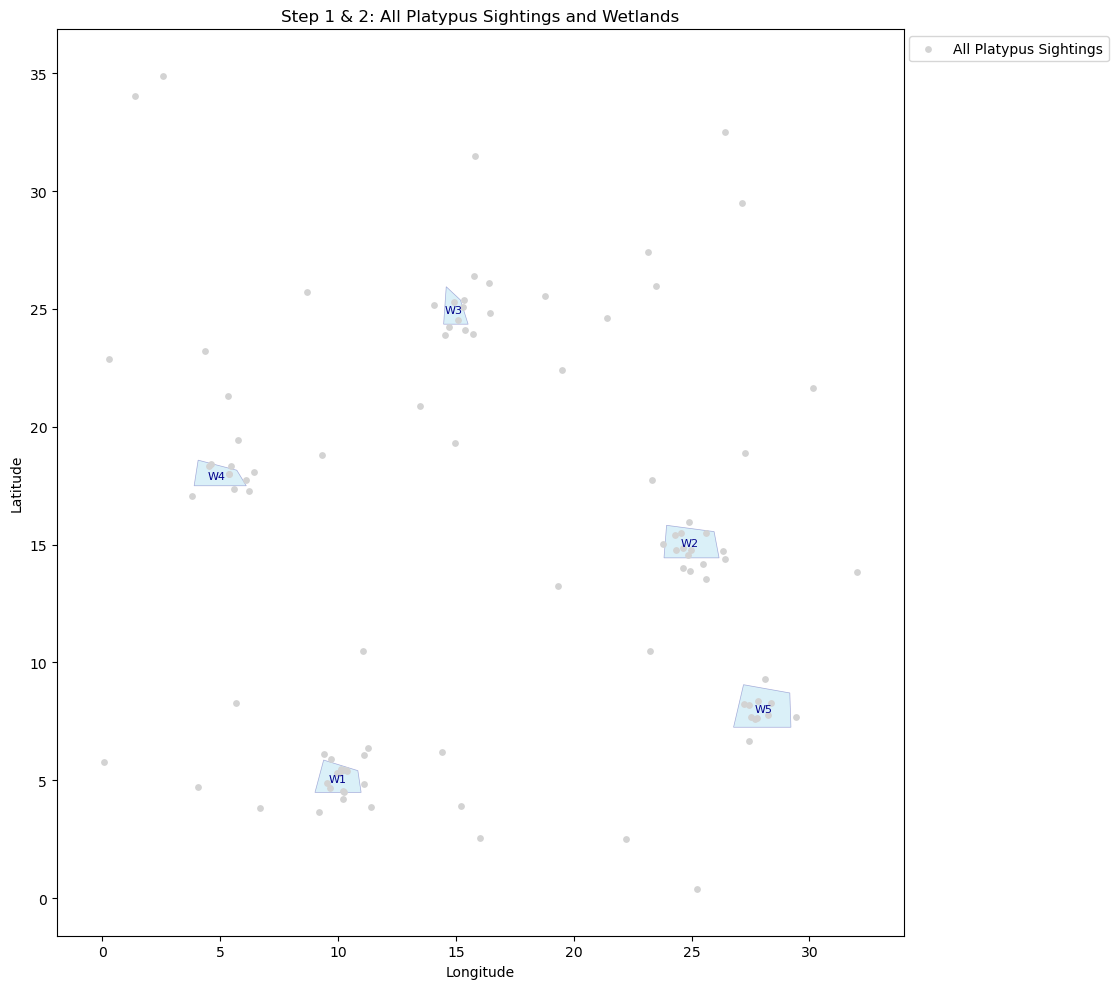

  Visualization created: step1_initial_data.png


In [61]:
# Step 2: Retrieve all wetland polygons
print("\nStep 2: Retrieving all wetland polygon geometries...")
all_wetlands = fetch_all_wetlands() # Dictionary: {w_id: (w_name, shapely.Polygon)}
print(f"  Fetched {len(all_wetlands)} wetland polygons.")

# Prepare wetlands for faster contains/distance checks
prepared_wetlands = {wid: (all_wetlands[wid][0], prep(w_poly)) for wid, (w_name, w_poly) in all_wetlands.items()}


# Visualization 1: All Platypus Sightings and Wetlands
plot_r_tree_distance_state('Step 1 & 2: All Platypus Sightings and Wetlands',
                           platypus_sightings, all_wetlands,
                           save_path='step1_initial_data.png')
print("  Visualization created: step1_initial_data.png")


Step 3: Building R-tree on wetland polygon MBRs...
  R-tree built successfully on wetland MBRs.


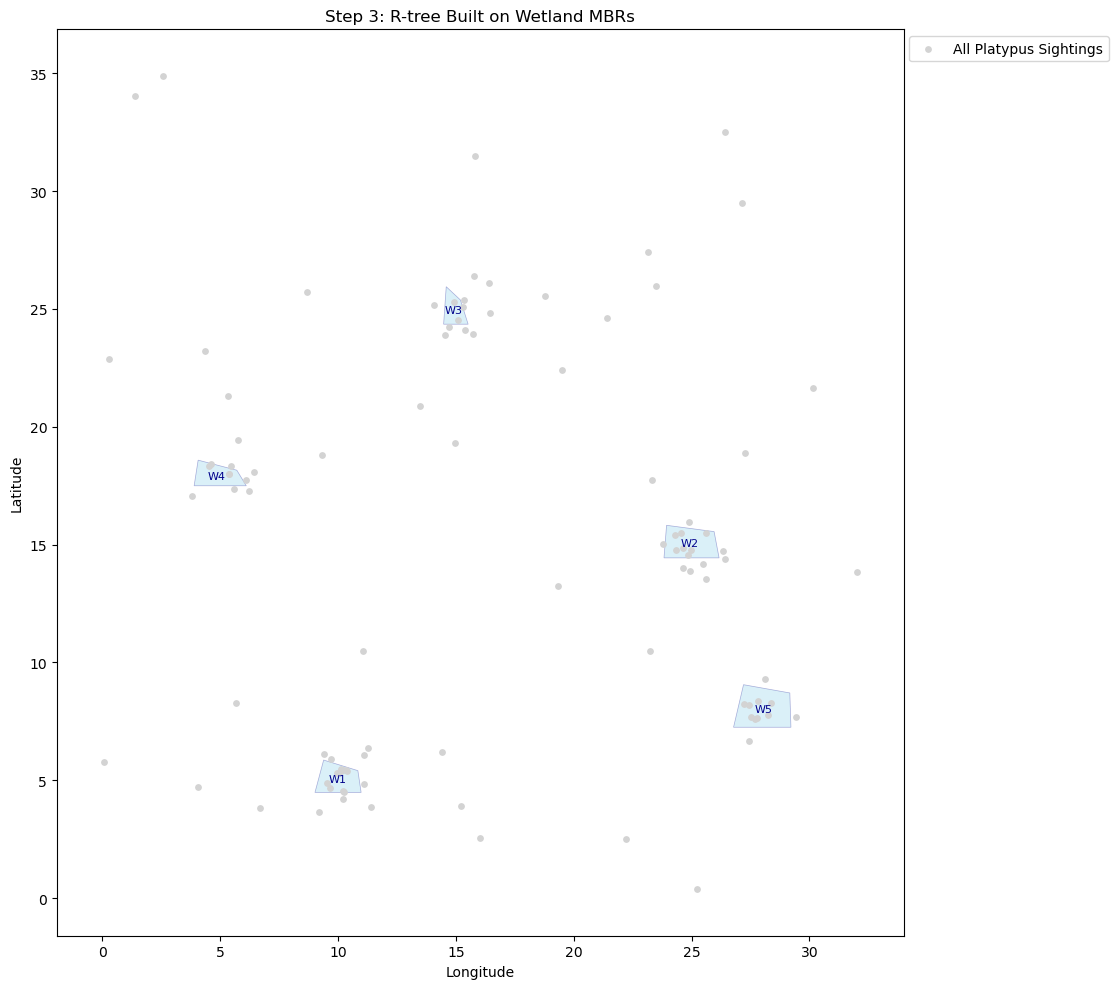

  Visualization created: step3_r_tree_built.png


In [62]:
# Step 3: Build an R-tree on these wetland polygons
print("\nStep 3: Building R-tree on wetland polygon MBRs...")
wetland_r_tree = index.Index()
for wid, (w_name, w_poly) in all_wetlands.items():
    wetland_r_tree.insert(wid, w_poly.bounds) # w_poly.bounds returns (min_x, min_y, max_x, max_y)
print("  R-tree built successfully on wetland MBRs.")

# Visualization 2: R-tree structure (showing MBRs of indexed wetlands)
# Rtree doesn't expose internal node structure easily, so we just plot object MBRs
plot_r_tree_distance_state('Step 3: R-tree Built on Wetland MBRs',
                           platypus_sightings, all_wetlands,
                           save_path='step3_r_tree_built.png')
print("  Visualization created: step3_r_tree_built.png")


Step 4 & 5: Processing each platypus sighting for closest wetland distance...


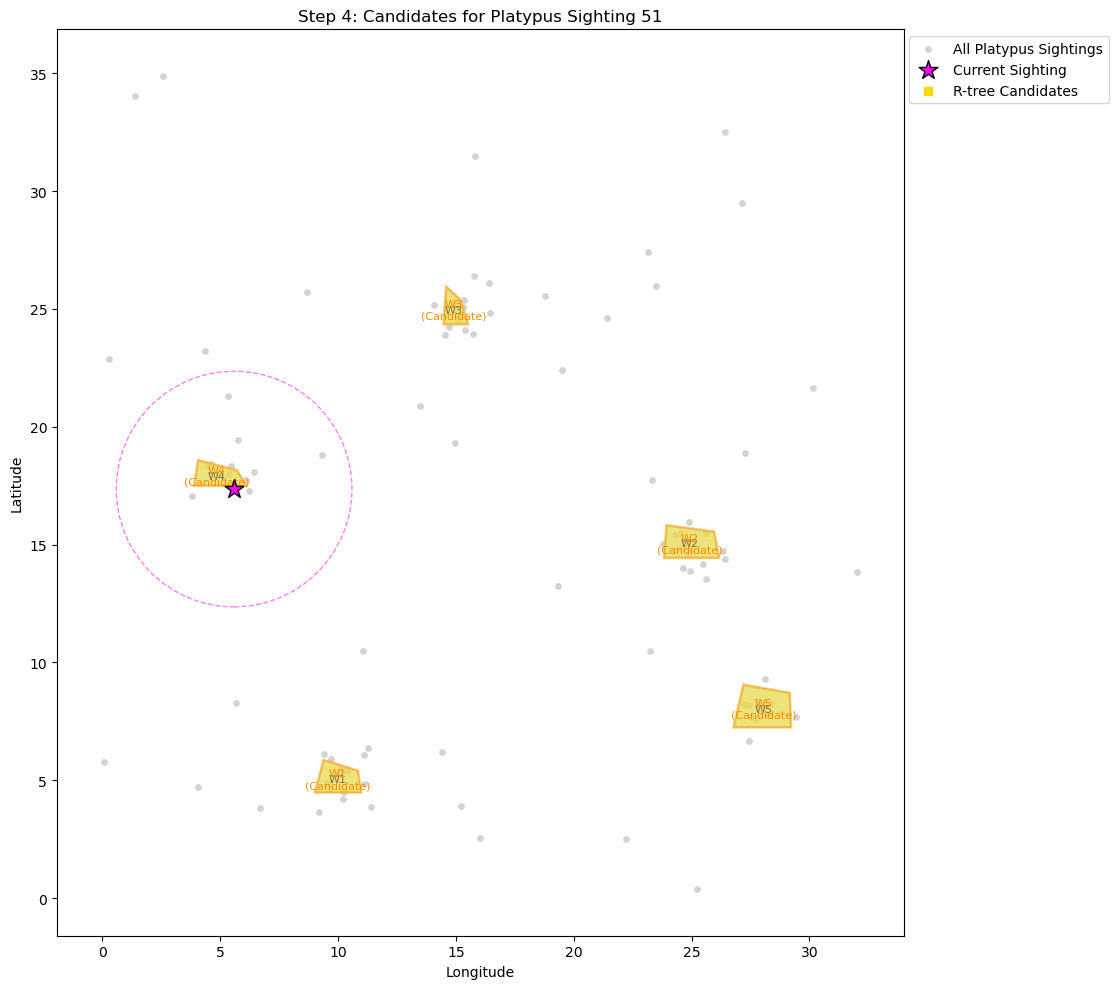

  Visualization created: step4_candidate_wetlands.png for sighting 51

Processed 100 platypus sightings.


In [64]:
# Step 4 & 5: Iterate through each platypus sighting, find closest wetlands
print("\nStep 4 & 5: Processing each platypus sighting for closest wetland distance...")
results = []
# Pick a sample sighting for detailed visualization
sample_sighting_for_viz = platypus_sightings[len(platypus_sightings) // 2] 


for s_data in platypus_sightings:
    s_point = Point(s_data.longitude, s_data.latitude)
    min_distance = float('inf')
    
    # 4a. Find closest wetland candidates (R-tree K-NN or BBox search)
    # Using nearest() for efficiency with a larger search space, or intersection() could be used with a buffer
    # Let's get top ~5 nearest MBRs for candidates, or all intersecting a buffer
    
    # Strategy 1: KNN search for a few nearest MBRs
    # rtree returns results as an iterator, so convert to list
    candidate_w_ids_rtree = list(wetland_r_tree.nearest(s_point.bounds, num_results=5, objects=False))
    
    # For visualization, only plot candidates for the sample sighting
    if s_data == sample_sighting_for_viz:
        plot_r_tree_distance_state(f'Step 4: Candidates for Platypus Sighting {s_data.sighting_id}',
                                   platypus_sightings, all_wetlands,
                                   current_sighting_point=s_point,
                                   candidate_wetland_ids=candidate_w_ids_rtree,
                                   save_path='step4_candidate_wetlands.png')
        print(f"  Visualization created: step4_candidate_wetlands.png for sighting {s_data.sighting_id}")

    # 4b. Check for containment (Refine Stage 1) and 4c/4d: Calculate precise distance (Refine Stage 2)
    current_sighting_distance = float('inf')
    
    # First, check if the point is *inside* any candidate wetland
    is_inside_any_wetland = False
    for wid in candidate_w_ids_rtree:
        w_name, p_w_poly = prepared_wetlands[wid] # Use prepared polygon for efficiency
        if p_w_poly.contains(s_point):
            current_sighting_distance = 0.0
            is_inside_any_wetland = True
            break # Found containment, no need to check others or distances
            
    if not is_inside_any_wetland:
        # If not inside, calculate precise distance to all candidates
        for wid in candidate_w_ids_rtree:
            w_name, orig_w_poly = all_wetlands[wid] # Use original polygon for distance calculation
            dist = s_point.distance(orig_w_poly) # Shapely distance calculation
            if dist < current_sighting_distance:
                current_sighting_distance = dist
    
    results.append((s_data, current_sighting_distance))

print(f"\nProcessed {len(results)} platypus sightings.")

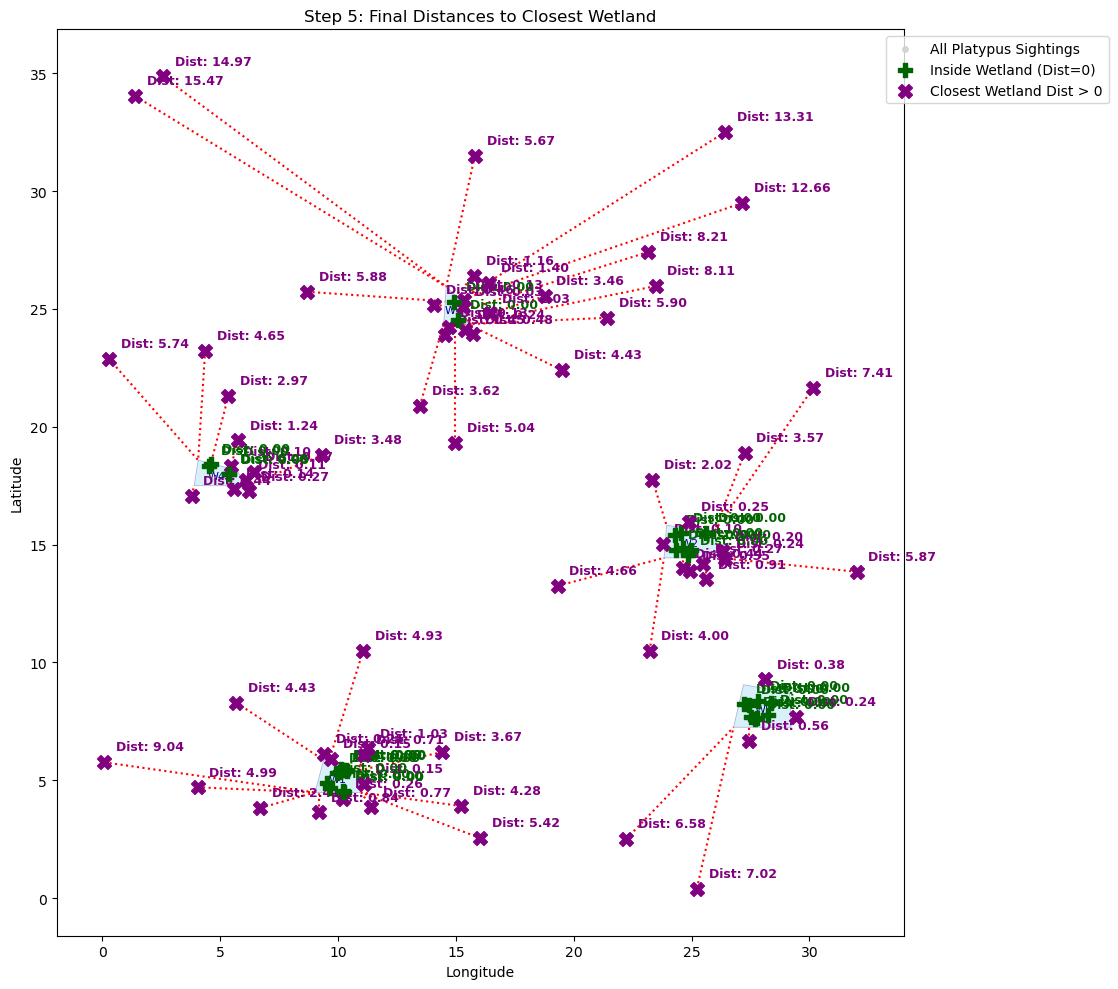

  Visualization created: step5_final_results.png

--- Execution Plan Complete ---


In [65]:

# Final Visualization: All platypus sightings with their calculated distances
plot_r_tree_distance_state('Step 5: Final Distances to Closest Wetland',
                           platypus_sightings, all_wetlands,
                           final_distances_by_sighting=results,
                           save_path='step5_final_results.png')
print("  Visualization created: step5_final_results.png")

print("\n--- Execution Plan Complete ---")